# Vertical deflection in a Kirchhoff-Love Plate, using firedrake

Work in progress. The goal is to treat an ice shelf as a rectangular thin plate, load it with some surface accumulation, and calculate the vertical elastic deflection. 

In [1]:
from firedrake import *
import matplotlib.pyplot as plt

Begin by exressing the variational form for linear elasticity as a minimization problem for the energy $\Pi$ (3.1):

$$\Pi(\vec{u}, \vec{v}) = \int_\Omega\left(\vec{\sigma}(\vec{u}):\vec{\varepsilon}(\vec{v})\right)d\Omega - \int_{\Gamma_t}(\vec{\sigma}(\vec{u})\cdot\vec{n})\cdot\vec{v}d\Gamma_t - \int_\Omega\vec{f}\cdot\vec{v}d\Omega.$$

This will be simplified using the constitutive relation for plane strain, under Kirchhoff's Hypothesis (see below). I'll write this relationship first using vector notation, since it allows easier comparison with MacAyeal et al., 2021, and then using tensor notation (since tensor notation works best with Firedrake). 


## Constitutive relation: vector notation 

The deflection vector $\vec{u}$ has components $u_x$, $u_y$, and $u_z := \eta$ ($\eta$ being depth-invariant by assumption). In this case, we use Kirchhoff's Hypothesis to write the horizontal deflections in terms of the vertical deflection, with $u_x = -\zeta\frac{\partial\eta}{\partial x}$ and $u_y = -\zeta\frac{\partial\eta}{\partial y}$ ($\zeta$ the vertical coordinate of the middle of the plate). Calculating the resulting strains, we find that the terms $\varepsilon_{xz}$, $\varepsilon_{yz}$, and $\varepsilon_{zz}$ disappear, and the remaining strains can be compactly expressed as (Eq. 5.3):

$$\vec{\varepsilon} = \begin{bmatrix}\varepsilon_{xx}\\ \varepsilon_{yy}\\ \varepsilon_{xy}\end{bmatrix} = -\zeta\begin{bmatrix}\frac{\partial^2\eta}{\partial x^2} \\ \frac{\partial^2\eta}{\partial y^2}\\ \frac{\partial^2\eta}{\partial x\partial y}\end{bmatrix} = -\zeta\begin{bmatrix}\frac{\partial^2}{\partial x^2} \\ \frac{\partial^2}{\partial y^2} \\ \frac{\partial^2}{\partial x\partial y}\end{bmatrix}\eta.$$

By Equation 4.3, the elimination of $\varepsilon_{zz}$ allows us to use the plane-strain approximation as the constitutive relation:

$$\vec{\sigma} = \begin{bmatrix}\sigma_{xx} \\ \sigma_{yy} \\ \sigma_{xy} \end{bmatrix} = \frac{E}{1 - \mu^2}\begin{bmatrix}1 & \mu & 0\\
\mu & 1 & 0\\
0 & 0 & 1 - \mu\end{bmatrix}\vec{\varepsilon} = -\zeta\frac{E}{1 - \mu^2}\begin{bmatrix}1 & \mu & 0\\
\mu & 1 & 0\\
0 & 0 & 1 - \mu\end{bmatrix}\begin{bmatrix}\frac{\partial^2\eta}{\partial x^2}\\
\frac{\partial^2\eta}{\partial y^2} \\ \frac{\partial^2\eta}{\partial x\partial y}\end{bmatrix}$$

As a side note, the bending moment can now be computed by multiplying both sides by $\zeta$ and integrating vertically from $-\frac{H}{2}$ to $\frac{H}{2}$. This procedure reproduces Eq. 34 from MacAyeal et al. (2021), using vector notation. 

## Constitutive relation: tensor notation

Alternatively, the equations above can be rewritten in tensor notation so that:

$$\vec{\varepsilon} = \begin{bmatrix}\varepsilon_{xx} & \varepsilon_{xy}\\
\varepsilon_{xy} & \varepsilon_{yy}
\end{bmatrix} = -\zeta\begin{bmatrix}\frac{\partial^2\eta}{\partial x^2} & \frac{\partial^2\eta}{\partial x\partial y}\\
\frac{\partial^2\eta}{\partial x\partial y} & \frac{\partial^2\eta}{\partial y^2}
\end{bmatrix} = -\zeta\nabla^2\eta$$

and (Eq. 4.3)

$$\vec{\sigma} = \begin{bmatrix} \sigma_{xx} & \sigma_{xy} \\
\sigma_{xy} & \sigma_{yy}
\end{bmatrix} = \frac{E}{1 + \mu}\left(\vec{\varepsilon} + \frac{\mu}{1 - \mu}tr(\vec{\varepsilon})\vec{I}\right) = -\zeta\frac{E}{1 + \mu}\left(\nabla^2\eta + \frac{\mu}{1 - \mu}tr(\nabla^2\eta)\vec{I}\right).$$

MacAyeal et al. suggest the following values for Poisson's ratio $\mu$ and Young's Modulus $E$:

In [2]:
E = 1e9 #Pacals
μ = 1/3

## Simplifying the variational form

Using tensor notation, and writing $\vec{v} = \begin{bmatrix}v_x & v_y & v\end{bmatrix}^T$, the variational form, written previously, becomes

$$\Pi(\vec{u}, \vec{v}) = \Pi(\eta, v) =  \frac{E}{1 + \mu}\int_\Omega\left[-\zeta\left(\nabla^2\eta + \frac{\mu}{1 - \mu}tr(\nabla^2\eta)\vec{I}\right):-\zeta\nabla^2v\right]d\Omega - \int_{\Gamma_t}(\vec{\sigma}\cdot\vec{n})\cdot\vec{v}d\Gamma_t - \int_\Omega f(x, y)v(x, y)d\Omega =$$

$$= \frac{E}{1 + \mu}\int_\Omega\left[\zeta^2\left(\nabla^2\eta + \frac{\mu}{1 - \mu}tr(\nabla^2\eta)\vec{I}\right):\nabla^2v\right]d\Omega - \int_{\Gamma_t}(\vec{\sigma}\cdot\vec{n})\cdot\vec{v}d\Gamma_t - \int_\Omega f(x, y)v(x, y)d\Omega.$$

Vertically integrating the first and third terms on the right from $-\frac{H}{2}$ to $\frac{H}{2}$, and introducing the shorthand $\lambda_1 := \frac{E}{1 + \mu}$ and $\lambda_2 := \frac{E}{1 + \mu}\left(\frac{\mu}{1 - \mu}\right)$, the variational form simplifies to

$$ \Pi(\eta, v) = \lambda_1\frac{H^3}{12}\int_{x, y}\nabla^2\eta : \nabla^2 v dxdy + \lambda_2\frac{H^3}{12}\int_{x, y}tr(\nabla^2\eta)\vec{I} : \nabla^2 vdxdy - \int_{\Gamma_t}(\vec{\sigma}\cdot\vec{n})\cdot\vec{v}d\Gamma_t - H\int_{x, y}f(x, y)v(x, y)dxdy.$$

In [3]:
λ_1 = E/(1 + μ)
λ_2 = E/(1 + μ)*μ/(1 - μ)

Noting finally that $tr(\nabla^2\eta)\vec{I} : \nabla^2 v = \Delta\eta\Delta v$ ($\Delta$ the Laplacian operator, which takes the divergence of the gradient), the form to be minimized is

$$\Pi(\eta, v) = \lambda_1\frac{H^3}{12}\int_{x, y}\nabla^2\eta : \nabla^2 v dxdy + \lambda_2\frac{H^3}{12}\int_{x, y}\Delta\eta\Delta vdxdy - \int_{\Gamma_t}(\vec{\sigma}\cdot\vec{n})\cdot\vec{v}d\Gamma_t - H\int_{x, y}f(x, y)v(x, y)dxdy.$$

## Spatial extent and mesh

In [4]:
nx, ny = 40, 20
Lx, Ly = 10000, 5000 #5 km long by 1 km wide shelf
mesh = RectangleMesh(nx, ny, Lx, Ly)

x, y = SpatialCoordinate(mesh)
Q = FunctionSpace(mesh, 'Argyris', 5)

## Physical parameters

In [5]:
ρ = 917 #ice density
g = 9.81 #g 
H = 100 #shelf thickness in meters

## Choose some physical forcing to bend the shelf

We can find examples of various physical forcings in Eq. 57 of MacAyeal et al. For example, there will be a downward force associated with any surface accumulation, $H_s$ (see Eq. 57c). I'll impose an artificial surface accumulation of one meter at the upstream boundary, linearly decreasing to zero at the downstream boundary:

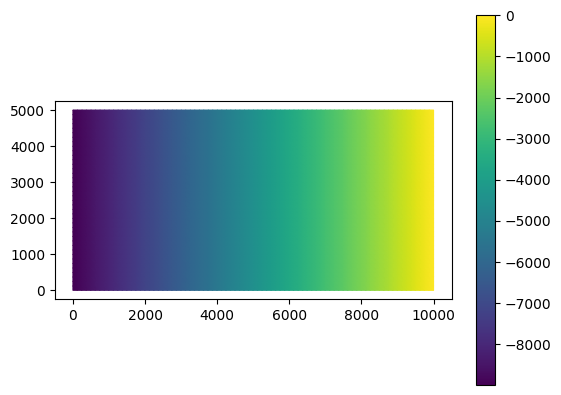

In [6]:
Hs = 1e-4*(Lx - x) #surface accumulation in meters, as a function of x
f = -ρ*g*Hs #weight as a function of surface accumulation (see Eq. 57c in MacAyeal et al., 2021)
F = project(f, Q) #one meter of accumulation upstream, linearly decreasing to zero downstream

fig, ax = plt.subplots() #and plot it
ax.set_aspect('equal')
force = tripcolor(F, axes=ax)
plt.colorbar(force)

## Set up the problem to be solved

We need to minimize the expression:

$$\Pi(\eta, v) = \lambda_1\frac{H^3}{12}\int_{x, y}\nabla^2\eta : \nabla^2 v dxdy + \lambda_2\frac{H^3}{12}\int_{x, y}\Delta\eta\Delta vdxdy - \int_{\Gamma_t}(\vec{\sigma}\cdot\vec{n})\cdot\vec{v}d\Gamma_t - H\int_{x, y}f(x, y)v(x, y)dxdy.$$

Currently unsure of how to impose boundary conditions.

In [7]:
η = Function(Q)
v = TestFunction(Q)

ddη = grad(grad(η))
ddv = grad(grad(v))
Δη = div(grad(η)) #the laplacian of η
Δv = div(grad(v)) #laplacian of v

L_1 = (λ_1*H**3/12*inner(ddη, ddv) + λ_2*H**3/12*Δη*Δv - H*F*v)*dx

#But what's a reasonable boundary condition to use?
#And how can we incorporate Dirichlet boundary conditions?
L_2 = λ_1*(η*v)*ds #temporarily borrowing this from the original version of this code, but unclear on physical significance
L = L_1 + L_2

## Solve and plot

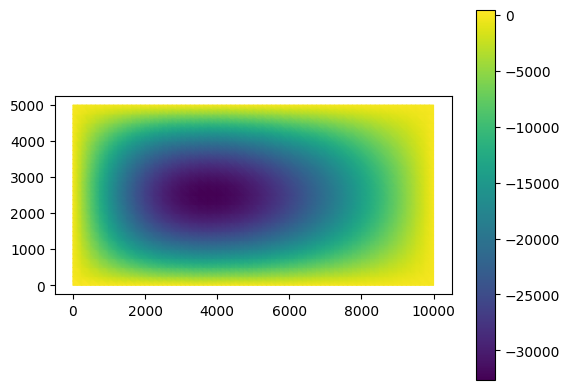

In [8]:
solve(L == 0, η)

fig, ax = plt.subplots()
ax.set_aspect('equal')
colors = tripcolor(η, axes = ax)
plt.colorbar(colors)

## Original code from June 21st meeting
```
nx, ny = 16, 16
mesh = UnitSquareMesh(nx, ny, diagonal = 'crossed')
element = FiniteElement('Argyris', 'triangle', 5) 
Q = FunctionSpace(mesh, element) 

x = SpatialCoordinate(mesh)
R = Constant(0.25)
ξ = Constant((0.5, 0.5))
f = -exp(-inner(x - ξ, x-ξ)/R**2) #downward force on the plate
F = project(f, Q)

fig, ax = plt.subplots()
force = tricontourf(F, axes=ax)
plt.colorbar(force)

μ = Constant(1.0)
λ = Constant(1.0)

η = Function(Q)
v = TestFunction(Q)

ddη = grad(grad(η))
ddv = grad(grad(v))
Δη = div(grad(η)) #the laplacian of w
Δv = div(grad(v)) #laplacian of v

h = CellSize(mesh)
L_1 = (μ*inner(ddη, ddv) + λ*Δη*Δv - F*v)*dx
L_2 = (μ + λ)*(η*v)/h**3*ds 
L_3 = (μ+λ)*h*inner(ddη, ddv)*ds

L = L_1 + L_2 + L_3

solve(L == 0, η)

fig, ax = plt.subplots()
ax.set_aspect('equal')
colors = tricontourf(η, axes = ax)
plt.colorbar(colors)
```